### Importing libraries

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

plt.style.use('seaborn-v0_8-muted')
%matplotlib inline

In [112]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\15148\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading and Inspecting the SMS Dataset

In [113]:
df= pd.read_csv(
  'sms-dataset.csv',
  encoding='latin-1',
  names = ['label','sms'],
  usecols=[0, 1], 
  header=0
)

df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Analyzing the Dataset for Insights

This section explores the SMS dataset to uncover patterns and trends that will inform model training.

In [114]:
df['label_bool'] = df.label.map({'ham':0, 'spam':1})
df['sms_len'] = df.sms.apply(len)
df.groupby('label')['sms_len'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4825.0,71.02,58.02,2.0,33.0,52.0,92.0,910.0
spam,747.0,138.87,29.18,13.0,132.5,149.0,157.0,224.0


### Graphing Data

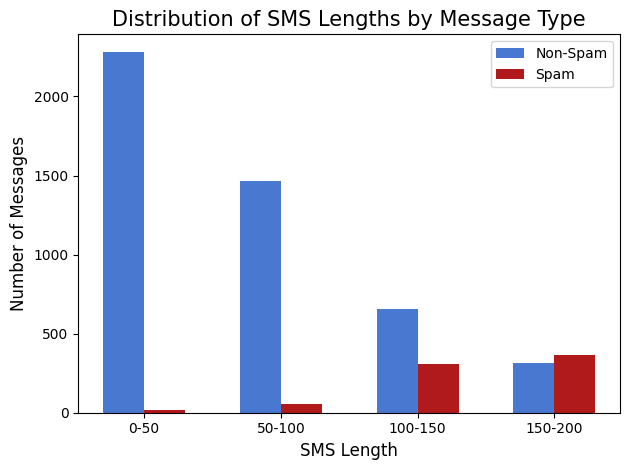

In [115]:
import matplotlib.pyplot as plt
import numpy as np

ham_sms = df[df["label"] == "ham"]
spam_sms = df[df["label"] == "spam"]

bins = [0, 50, 100, 150, 200]

ham_counts, bin_edges_ham = np.histogram(ham_sms['sms_len'], bins=bins)
spam_counts, bin_edges_spam = np.histogram(spam_sms['sms_len'], bins=bins)

# Set bar width and positions
bar_width = 0.3
index = np.arange(len(bins) - 1)

# Plot bars for ham and spam using plt.bar()
plt.bar(index, ham_counts, bar_width, label='Non-Spam')
plt.bar(index + bar_width, spam_counts, bar_width, label='Spam', color='#b01a1a')

# Set labels, title, and ticks
plt.xlabel('SMS Length', fontsize=12)
plt.ylabel('Number of Messages', fontsize=12)
plt.title('Distribution of SMS Lengths by Message Type', fontsize=15)
plt.xticks(index + bar_width / 2, ['0-50', '50-100', '100-150', '150-200'])

# Add legend
plt.legend()

# Show plot with plt
plt.tight_layout()
plt.show()


Most non-spam messages are short, while spam messages are more evenly distributed across longer SMS lengths. Interestingly, <br>
in the 150-200 character range, spam messages are more frequent than non-spam, despite the overall dominance of non-spam messages. <br>
This suggests that message length could be a useful feature for distinguishing between spam and non-spam.<br><br>
Due to the imbalance between spam and non-spam messages, we should use models with balanced class weight, as it will <br>
help improve spam detection by giving more weight to the 'Spam' class.

# Removing Unnecessary Text and Applying Stemming

Filter the raw SMS messages by removing unnecessary characters (e.g., punctuation) and transforming them into stemmed lowercase words to improve model performance.

In [116]:
from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer

ps = PorterStemmer()

def filter_text(sms):
  stopwords_set = set(stopwords.words('english') + ['u', 'ur', 'im', '2'])
  
  no_punct_str = ""
  for char in sms:
    if char not in string.punctuation:
      no_punct_str+=char

  words = no_punct_str.split()
  
  filtered_words = []
  for word in words:
    if word.lower() not in stopwords_set:
      stemmed_word = ps.stem(word.lower())
      filtered_words.append(stemmed_word)
  
  return ' '.join(filtered_words)

df['filtered_sms'] = df['sms'].apply(filter_text)
df[['label', 'filtered_sms']].head()


,label,filtered_sms
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif oni
2,spam,free entri wkli comp win fa cup final tkt 21st...
3,ham,dun say earli hor c alreadi say
4,ham,nah dont think goe usf live around though


### Most Used Words

In [117]:
from collections import Counter

def count_words(df, label):
  words = df[df.label == label].filtered_sms
  count = Counter()

  for sms in words:
    word_list = sms.split()
    count.update(word_list)

  most_common_words = count.most_common(5)

  return pd.DataFrame(most_common_words, columns=['Word', 'Count'])

print(5*" " + "Ham")
display(count_words(df, 'ham').style.hide())
print("\n"+5*" " + "Spam")
display(count_words(df, 'spam').style.hide())

     Ham


Word,Count
go,414
get,360
come,292
call,287
ltgt,276



     Spam


Word,Count
call,366
free,216
txt,163
text,138
mobil,135


# Converting Text to Numerical Representations

Convert the filtered SMS messages into a numerical format using the TF-IDF vectorizer, which transforms text data into numerical values based on term frequency <br>
and inverse document frequency.

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Vectorize the SMS data using TF-IDF for both training and testing sets

X = df.filtered_sms
y = df.label_bool

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

features = vectorizer.get_feature_names_out()

tfidf_array = X_train_tfidf[0].toarray().flatten()
sorted_indices = tfidf_array.argsort()[::-1]
top_indices = sorted_indices[:10]

top_scores=[]

for i in top_indices:
  word = features[i]          
  score = tfidf_array[i]      
  top_scores.append((word, score))
 
top_words_df = pd.DataFrame(top_scores, columns=['Word', 'TF-IDF Score'])

display(top_words_df.style.format({'TF-IDF Score': '{:.4f}'}).hide())


Word,TF-IDF Score
wer,0.5239
plane,0.3329
student,0.3049
made,0.2628
aeronaut,0.1746
aeroplan,0.1746
calld,0.1746
professor,0.1746
saidif,0.1746
height,0.1664


# Testing and Comparing Machine Learning Models (Speed, Accuracy and Metrics)


We will be performing tests to determine which algorithm is the most efficient to use with our dataset.<br>
The evaluation will be based on speed, accuracy, and the rates of false positives and false negatives (recall) for each label.

#### Implementing Testing Logic

In [119]:
from sklearn import metrics
import timeit as t

# Test model: display accuracy, speed, and detailed metrics

def perform_tests(model):
  
  y_pred_class = model.predict(X_test_tfidf)
  
  accuracy = model.score(X_test_tfidf, y_test)*100
  prediction_time = t.timeit(lambda: model.predict(X_test_tfidf), number=1)
  
  print(f"Prediction Time: {prediction_time:.4f} seconds")
  print(f"Accuracy: {accuracy:.4f} %\n\n")
  print(f'Details: \n {metrics.classification_report(y_test, y_pred_class, target_names=['Non-Spam', 'Spam'])}')
    

## 1. Naive Bayes Model

In [120]:
from sklearn.naive_bayes import MultinomialNB
import timeit as t

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [121]:
perform_tests(nb)

Prediction Time: 0.0003 seconds
Accuracy: 96.6978 %


Details: 
               precision    recall  f1-score   support

    Non-Spam       0.96      1.00      0.98      1213
        Spam       1.00      0.74      0.85       180

    accuracy                           0.97      1393
   macro avg       0.98      0.87      0.92      1393
weighted avg       0.97      0.97      0.96      1393



## 2. SVC Model

In [122]:
from sklearn.svm import SVC

svc = SVC(kernel='linear', class_weight='balanced')
svc.fit(X_train_tfidf, y_train)

SVC(class_weight='balanced', kernel='linear')

In [123]:
perform_tests(svc)

Prediction Time: 0.1157 seconds
Accuracy: 98.7796 %


Details: 
               precision    recall  f1-score   support

    Non-Spam       0.99      1.00      0.99      1213
        Spam       0.97      0.93      0.95       180

    accuracy                           0.99      1393
   macro avg       0.98      0.96      0.97      1393
weighted avg       0.99      0.99      0.99      1393



## <mark>3. Logistic Regression Model </mark>

In [124]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced')

In [125]:
perform_tests(lr)

Prediction Time: 0.0003 seconds
Accuracy: 97.7746 %


Details: 
               precision    recall  f1-score   support

    Non-Spam       0.99      0.98      0.99      1213
        Spam       0.90      0.93      0.92       180

    accuracy                           0.98      1393
   macro avg       0.94      0.96      0.95      1393
weighted avg       0.98      0.98      0.98      1393

